<span style="color: green;">

# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

</span>


You have to run the following instruction to create your conda env:

- conda create --name Lab4_DLA
- conda activate Lab4_DLA
- conda install pytorch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 pytorch-cuda=11.8 -c pytorch -c nvidia
- pip install scikit-learn


### Import


In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision.datasets import CIFAR10, CIFAR100
import torchvision.transforms as transforms
from torch.utils.data import Subset
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
    classification_report,
)

### Device


In [3]:
i = 1
if torch.cuda.is_available():
    device = torch.device("cuda:" + str(i))  # cuda:0 , cuda:1
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # yes, i have a MacBookPro with M1 Pro
else:
    device = torch.device("cpu")

print(f"device: {device}")
print(
    "GPU: " + torch.cuda.get_device_name(i)
    if device == torch.device("cuda:" + str(i))
    else ""
)

device: cuda:1
GPU: NVIDIA RTX A2000 12GB


<span style="color: green;">

## Exercise 1: OOD Detection and Performance Evaluation

In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

</span>


<span style="color: green;">

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

- CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are _not_ in CIFAR-10 (see `torch.utils.data.Subset`).
- Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
- Something else, but if using images keep the images reasonably small!

In this exercise your _OOD Detector_ should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

</span>


### Iperparametri


In [4]:
batch_size = 1
epochs = 20
lr = 0.01
val_size = 10000
epochs = 50

Le funzioni della cella hannno lo scopo di capire come sono distribuite le label del dataset preso in considerazione e calcolare i valori per normalizzare le immagini.


In [5]:
# plot label distribution with string


def plot_hist_labels_distribution_string(data, num_classes, split, position):
    if split == "train":
        labels_train = [y for _, y in data]
        all_labels = torch.tensor([value for value in list(labels_train)]).float()
        classes = data.dataset.classes
    elif split == "val":
        labels_val = [y for _, y in data]
        all_labels = torch.tensor([value for value in list(labels_val)]).float()
        classes = data.dataset.classes
    elif split == "test":
        all_labels = torch.tensor([value for value in list(data.targets)]).float()
        classes = data.classes

    hist = torch.histc(all_labels, bins=num_classes)
    plt.subplot(1, 3, position)
    plt.bar(range(num_classes), hist, align="center")
    plt.xlabel("Labels")
    plt.ylabel("Number of Examples")
    if num_classes <= 10:
        plt.xticks(np.arange(0, num_classes, 1), classes, rotation=90)
    plt.title(split + " " + "Set Label Distribution")


# for mnist: get_normalize_values(ds_train_initial.data.float())
# for cifar10: get_normalize_values(ds_train_initial.data)


def get_normalize_values(data):
    return (
        data.mean(axis=(0, 1, 2)) / 255,
        data.std(axis=(0, 1, 2)) / 255,
    )

## Dataset In-Distribution (cifar-10)


In [6]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.49139968, 0.48215841, 0.44653091),
            (0.24703223, 0.24348513, 0.26158784),
        ),
    ]
)

ds_train_initial = CIFAR10(
    root="../dataset/", train=True, download=True, transform=transform
)
num_classes = len(ds_train_initial.classes)
id_ds_test = CIFAR10(
    root="../dataset/", train=False, download=True, transform=transform
)

n_examples_test = len(id_ds_test)
print(f"Classes: {ds_train_initial.class_to_idx}")

I = np.random.permutation(len(ds_train_initial))
id_ds_val = Subset(ds_train_initial, I[:val_size])
n_examples_val = len(id_ds_val)

id_ds_train = Subset(ds_train_initial, I[val_size:])
n_examples_train = len(id_ds_train)

print(f"N° samples train: {n_examples_train}")
print(f"N° samples validation: {n_examples_val}")
print(f"N° samples test: {n_examples_test}")
# Imposta la dimensione della figura per contenere i 3 grafici in riga

# plt.figure(figsize=(15, 5))

plot_hist_labels_distribution_string(id_ds_train, num_classes, "train", 1)
plot_hist_labels_distribution_string(id_ds_val, num_classes, "val", 2)
plot_hist_labels_distribution_string(id_ds_test, num_classes, "test", 3)

# plt.tight_layout()  # Ottimizza lo spaziamento tra i grafici

id_dl_train = torch.utils.data.DataLoader(
    id_ds_train, batch_size, shuffle=True, num_workers=4
)
id_dl_val = torch.utils.data.DataLoader(id_ds_val, batch_size, num_workers=4)
id_dl_test = torch.utils.data.DataLoader(
    id_ds_test, batch_size, shuffle=False, num_workers=4
)

num_batch_train = len(id_dl_train)
num_batch_val = len(id_dl_val)
num_batch_test = len(id_dl_test)

print(f"N° batches train: {num_batch_train}")
print(f"N° batches val: {num_batch_val}")
print(f"N° batches test: {num_batch_test}")

id_classes = ds_train_initial.classes

id2label = {v: k for k, v in ds_train_initial.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified
Classes: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
N° samples train: 40000
N° samples validation: 10000
N° samples test: 10000
N° batches train: 40000
N° batches val: 10000
N° batches test: 10000


## Dataset Out-of-Distribution (cifar100)


In [7]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.50707516, 0.48654887, 0.44091784),
            (0.26733429, 0.25643846, 0.27615047),
        ),
    ]
)

ds_train_initial = CIFAR100(
    root="../dataset/", train=True, download=True, transform=transform
)
num_classes = len(ds_train_initial.classes)
ood_ds_test = CIFAR100(
    root="../dataset/", train=False, download=False, transform=transform
)

n_examples_test = len(ood_ds_test)

print(f"Classes: {ds_train_initial.class_to_idx}")

I = np.random.permutation(len(ds_train_initial))
ood_ds_val = Subset(ds_train_initial, I[:val_size])
n_examples_val = len(ood_ds_val)

ood_ds_train = Subset(ds_train_initial, I[val_size:])
n_examples_train = len(ood_ds_train)

print(f"N° samples train: {n_examples_train}")
print(f"N° samples validation: {n_examples_val}")
print(f"N° samples test: {n_examples_test}")
# Imposta la dimensione della figura per contenere i 3 grafici in riga

# plt.figure(figsize=(15, 5))

# plot_hist_labels_distribution_string(ood_ds_train, num_classes, "train", 1)
# plot_hist_labels_distribution_string(ood_ds_val, num_classes, "val", 2)
# plot_hist_labels_distribution_string(ood_ds_test, num_classes, "test", 3)

# plt.tight_layout()  # Ottimizza lo spaziamento tra i grafici

ood_dl_train = torch.utils.data.DataLoader(
    ood_ds_train, batch_size, shuffle=True, num_workers=4
)
ood_dl_val = torch.utils.data.DataLoader(ood_ds_val, batch_size, num_workers=4)
ood_dl_test = torch.utils.data.DataLoader(
    ood_ds_test, batch_size, shuffle=False, num_workers=4
)

num_batch_train = len(ood_dl_train)
num_batch_val = len(ood_dl_val)
num_batch_test = len(ood_dl_test)

print(f"N° batches train: {num_batch_train}")
print(f"N° batches val: {num_batch_val}")
print(f"N° batches test: {num_batch_test}")

ood_classes = ds_train_initial.classes

Files already downloaded and verified
Classes: {'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'bear': 3, 'beaver': 4, 'bed': 5, 'bee': 6, 'beetle': 7, 'bicycle': 8, 'bottle': 9, 'bowl': 10, 'boy': 11, 'bridge': 12, 'bus': 13, 'butterfly': 14, 'camel': 15, 'can': 16, 'castle': 17, 'caterpillar': 18, 'cattle': 19, 'chair': 20, 'chimpanzee': 21, 'clock': 22, 'cloud': 23, 'cockroach': 24, 'couch': 25, 'crab': 26, 'crocodile': 27, 'cup': 28, 'dinosaur': 29, 'dolphin': 30, 'elephant': 31, 'flatfish': 32, 'forest': 33, 'fox': 34, 'girl': 35, 'hamster': 36, 'house': 37, 'kangaroo': 38, 'keyboard': 39, 'lamp': 40, 'lawn_mower': 41, 'leopard': 42, 'lion': 43, 'lizard': 44, 'lobster': 45, 'man': 46, 'maple_tree': 47, 'motorcycle': 48, 'mountain': 49, 'mouse': 50, 'mushroom': 51, 'oak_tree': 52, 'orange': 53, 'orchid': 54, 'otter': 55, 'palm_tree': 56, 'pear': 57, 'pickup_truck': 58, 'pine_tree': 59, 'plain': 60, 'plate': 61, 'poppy': 62, 'porcupine': 63, 'possum': 64, 'rabbit': 65, 'raccoon': 66, 'r

In [78]:
# prendi le classi di cifar100 che non sono in cifar10
# print(id_classes + ood_classes)
# print(len(set(id_classes + ood_classes)))

# You will need to wrap CIFAR-100 in some way to select a subset
# of classes that are _not_ in CIFAR-10 (see `torch.utils.data.Subset`).

# NO, cifar10 e cifar100 non hanno nessuna classe in comune

## Choose ID & OOD Dataset


L'idea è quella di eseguire l'addestramento sul dataset di train di cifar10. Dopodichè prendiamo in esame due test set: uno in-distribution (cifar10) e uno out-of-distribution (cifar100). Entrambi i test set hanno una dimensione di 10000 esempi.


In [8]:
id_train = id_dl_train  # 10 classi
in_data = id_dl_test  # 10 classi
ood_data = ood_dl_test  # 100 classi

### Model


In [79]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Training Loop


In [10]:
os.makedirs("./model/", exist_ok=True)
path_model = "./model/model.pth"
model = CNN().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

if not os.path.exists(path_model):
    for epoch in range(epochs):
        running_loss = 0.0
        # Iterate over all batches.
        for i, (Xs, ys) in enumerate(id_dl_train, 0):
            Xs = Xs.to(device)
            ys = ys.to(device)

            # Make a gradient step.
            optimizer.zero_grad()
            outputs = model(Xs)
            loss = criterion(outputs, ys)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average epoch loss.
        print(f"{epoch + 1} loss: {running_loss / len(id_dl_train):.3f}")

    print("Finished Training")

    torch.save(model.state_dict(), path_model)
else:
    print(f"Model saved on path {path_model}")

Model saved on path ./model/model.pth


### Pre-trained Model


In [11]:
model.load_state_dict(torch.load(path_model))
model

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Come abbiamo fatto nella lezione flipped, stampiamo gli istrogrammi dei valori dei logits. Qui in particolare si vuole capire cosa succede al massimo valore del logits considerando i test set IN e OUT distribution.


In [12]:
# Function to collect all logits from the model on entire dataset.
def collect_logits(model, dl):
    logits = []
    with torch.no_grad():
        for Xs, _ in dl:
            logits.append(model(Xs.to(device)).cpu().numpy())
    return np.vstack(logits)


def hist_id_ood(model, in_data, ood_data):
    # Collect logits on CIFAR-10 test set (ID) and CIFAR-100 (OOD).
    logits_ID = collect_logits(model, in_data)
    logits_OOD = collect_logits(model, ood_data)
    # Plot the *distribution* of max logit outputs.
    _ = plt.hist(logits_ID.max(1), 50, density=True, alpha=0.5, label="ID")
    _ = plt.hist(logits_OOD.max(1), 50, density=True, alpha=0.5, label="OOD")
    plt.legend()

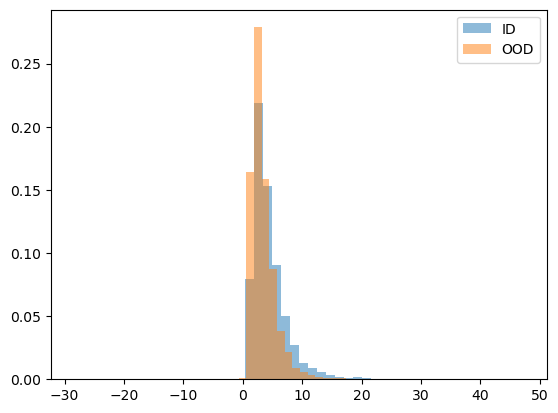

In [13]:
hist_id_ood(model, in_data, ood_data)

Le due distribuzioni sono molto sovrapposte. Questo porta ad un grave problema: se diamo in pasto alla rete un esempio OOD questo verrà classificato con una alta confidenza come un valore in distribution. Gli esperimenti successivi tentano di fornire una misura quantitativa di quanto un sistema presenta questo problema. Faremo grande uso di metrice standard di un problema di classificazione.


<span style="color: green;">

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for _both_ ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

- [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
- [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)

</span>


## Area under the ROC curve for ID classification


In [14]:
def collect_logits(model, dl):
    logits = list()
    with torch.no_grad():
        for x, _ in dl:
            logits.append(model(x.to(device)).cpu())
    return torch.cat(logits, dim=0)  # ritorno un tensore pytorch


def prob_score(logits):
    prob = torch.softmax(logits, dim=1)
    return prob.max(dim=1).values

In [15]:
logits_ID = collect_logits(model, in_data)  # len = 10K
logits_OOD = collect_logits(model, ood_data)  # len = 10K

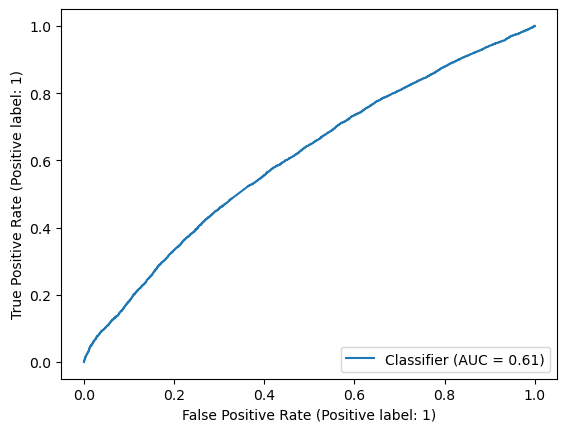

In [16]:
labels_ID = np.array([1 for _ in range(len(logits_ID))])
labels_OOD = np.array([0 for _ in range(len(logits_OOD))])
y = np.concatenate([labels_ID, labels_OOD])  # len = 20K
score_prob_ID = prob_score(logits_ID)
score_prob_OOD = prob_score(logits_OOD)
pred = np.concatenate([score_prob_ID, score_prob_OOD])
RocCurveDisplay.from_predictions(y, pred)

## Area under the Precision-Recall curve for both ID and OOD scoring


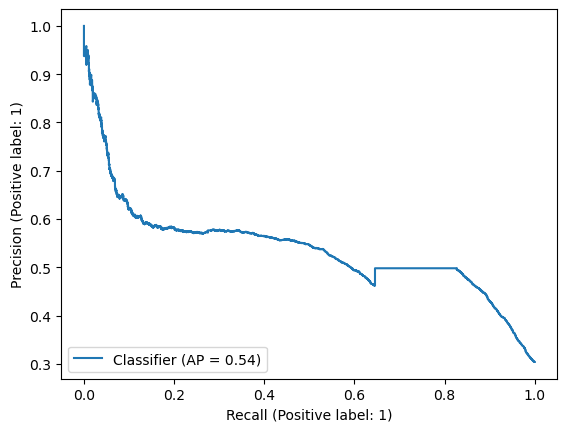

In [77]:
labels_ID = np.array([1 for _ in range(len(logits_ID))])
labels_OOD = np.array([0 for _ in range(len(logits_OOD))])
y = np.concatenate([labels_ID, labels_OOD])  # len = 20K
score_prob_ID = prob_score(logits_ID)
score_prob_OOD = prob_score(logits_OOD)
pred = np.concatenate([score_prob_ID, score_prob_OOD])
PrecisionRecallDisplay.from_predictions(y, pred)

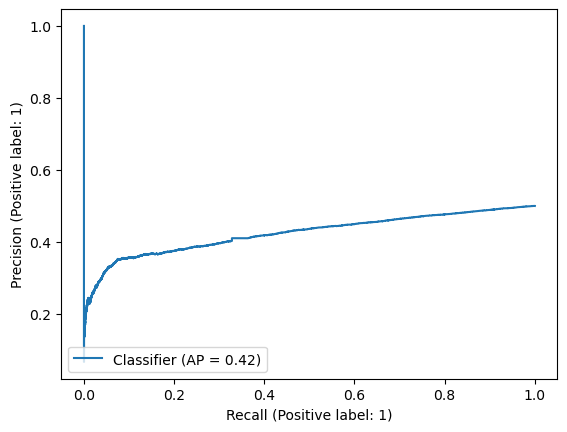

In [18]:
labels_ID = np.array([0 for _ in range(len(logits_ID))])
labels_OOD = np.array([1 for _ in range(len(logits_OOD))])
y = np.concatenate([labels_ID, labels_OOD])  # len = 20K
score_prob_ID = prob_score(logits_ID)
score_prob_OOD = prob_score(logits_OOD)
pred = np.concatenate([score_prob_ID, score_prob_OOD])
PrecisionRecallDisplay.from_predictions(y, pred)

<span style="color: green;">

---

## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks.

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla\_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are.

</span>


<span style="color: green;">

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation _on the fly_ so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

</span>


In [ ]:
# implement FGSM
# ho un esempio
# perturbo l'esempio
# genera esempi adversarial a partire dagli esempi usati durante il training
# metti a confronto gli esempi originali con quelli adversarial
# fai il confronto muovendo epsilon

In [19]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [20]:
# restores the tensors to their original scale
def denorm(
    batch,
    mean=[0.49139968, 0.48215841, 0.44653091],
    std=[0.24703223, 0.24348513, 0.26158784],
):
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [21]:
def test(model, device, test_loader, epsilon):
    correct = 0
    adv_examples = []
    logits = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        data.requires_grad = True

        output = model(data)
        output_prob = torch.softmax(output, dim=1)
        # get the index of the max softmax probability
        init_pred = output_prob.max(1, keepdim=True)[1]

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.cross_entropy(output, target)
        model.zero_grad()
        loss.backward()

        data_grad = data.grad.data
        data_denorm = denorm(data)

        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        perturbed_data_normalized = transforms.Normalize(
            (0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)
        )(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # collect logits
        logits.append(output.detach().cpu())

        # Check for success
        output_prob = torch.softmax(output, dim=1)
        final_pred = output_prob.max(1, keepdim=True)[1]

        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
    # Calculate final accuracy for this epsilon
    final_acc = correct / float(len(test_loader))
    print(
        f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}"
    )
    logits_ID = torch.cat(logits, dim=0)

    return final_acc, adv_examples, logits_ID

In [ ]:
"""def roc_curve(logits_ID, logits_OOD):
    labels_ID = np.array([1 for _ in range(len(logits_ID))])
    labels_OOD = np.array([0 for _ in range(len(logits_OOD))])
    y = np.concatenate([labels_ID, labels_OOD])  # len = 20K
    score_prob_ID = prob_score(logits_ID)
    score_prob_OOD = prob_score(logits_OOD)
    pred = np.concatenate([score_prob_ID, score_prob_OOD])
    disp = RocCurveDisplay.from_predictions(y, pred)
    plt.title("Area under the ROC curve for ID classification")
    plt.plot()


def pr_curve(logits_ID, logits_OOD, label_positive="id"):
    if label_positive == "id":
        labels_ID = np.array([1 for _ in range(len(logits_ID))])
        labels_OOD = np.array([0 for _ in range(len(logits_OOD))])
    if label_positive == "ood":
        labels_ID = np.array([0 for _ in range(len(logits_ID))])
        labels_OOD = np.array([1 for _ in range(len(logits_OOD))])
    y = np.concatenate([labels_ID, labels_OOD])  # len = 20K
    score_prob_ID = prob_score(logits_ID)
    score_prob_OOD = prob_score(logits_OOD)
    pred = np.concatenate([score_prob_ID, score_prob_OOD])
    disp = PrecisionRecallDisplay.from_predictions(y, pred)
    plt.title(
        f"Area under the Precision-Recall curve for {label_positive.upper()} scoring"
    )
    plt.plot()
"""
pass

In [22]:
def roc_curve(logits_ID, logits_OOD, eps, ax):
    labels_ID = np.array([1 for _ in range(len(logits_ID))])
    labels_OOD = np.array([0 for _ in range(len(logits_OOD))])
    y = np.concatenate([labels_ID, labels_OOD])
    score_prob_ID = prob_score(logits_ID)
    score_prob_OOD = prob_score(logits_OOD)
    pred = np.concatenate([score_prob_ID, score_prob_OOD])

    if ax is not None:
        RocCurveDisplay.from_predictions(y, pred, ax=ax, name=f"eps= {eps} ")
        ax.set_title("AUROC curve for ID classification")
        ax.legend(loc="best")


def pr_curve(logits_ID, logits_OOD, label_positive, eps, ax):
    if label_positive == "id":
        labels_ID = np.array([1 for _ in range(len(logits_ID))])
        labels_OOD = np.array([0 for _ in range(len(logits_OOD))])
        title = "AUPRC curve for ID scoring"
    if label_positive == "ood":
        labels_ID = np.array([0 for _ in range(len(logits_ID))])
        labels_OOD = np.array([1 for _ in range(len(logits_OOD))])
        title = "AUPRC curve for OOD scoring"

    y = np.concatenate([labels_ID, labels_OOD])
    score_prob_ID = prob_score(logits_ID)
    score_prob_OOD = prob_score(logits_OOD)
    pred = np.concatenate([score_prob_ID, score_prob_OOD])

    if ax is not None:
        PrecisionRecallDisplay.from_predictions(y, pred, ax=ax, name=f"eps= {eps} ")
        ax.set_title(title)
        ax.legend(loc="best")

Epsilon: 0	Test Accuracy = 4369 / 10000 = 0.4369
Epsilon: 0.05	Test Accuracy = 1079 / 10000 = 0.1079
Epsilon: 0.1	Test Accuracy = 1200 / 10000 = 0.12
Epsilon: 0.15	Test Accuracy = 1185 / 10000 = 0.1185
Epsilon: 0.2	Test Accuracy = 1189 / 10000 = 0.1189
Epsilon: 0.25	Test Accuracy = 1140 / 10000 = 0.114
Epsilon: 0.3	Test Accuracy = 1083 / 10000 = 0.1083


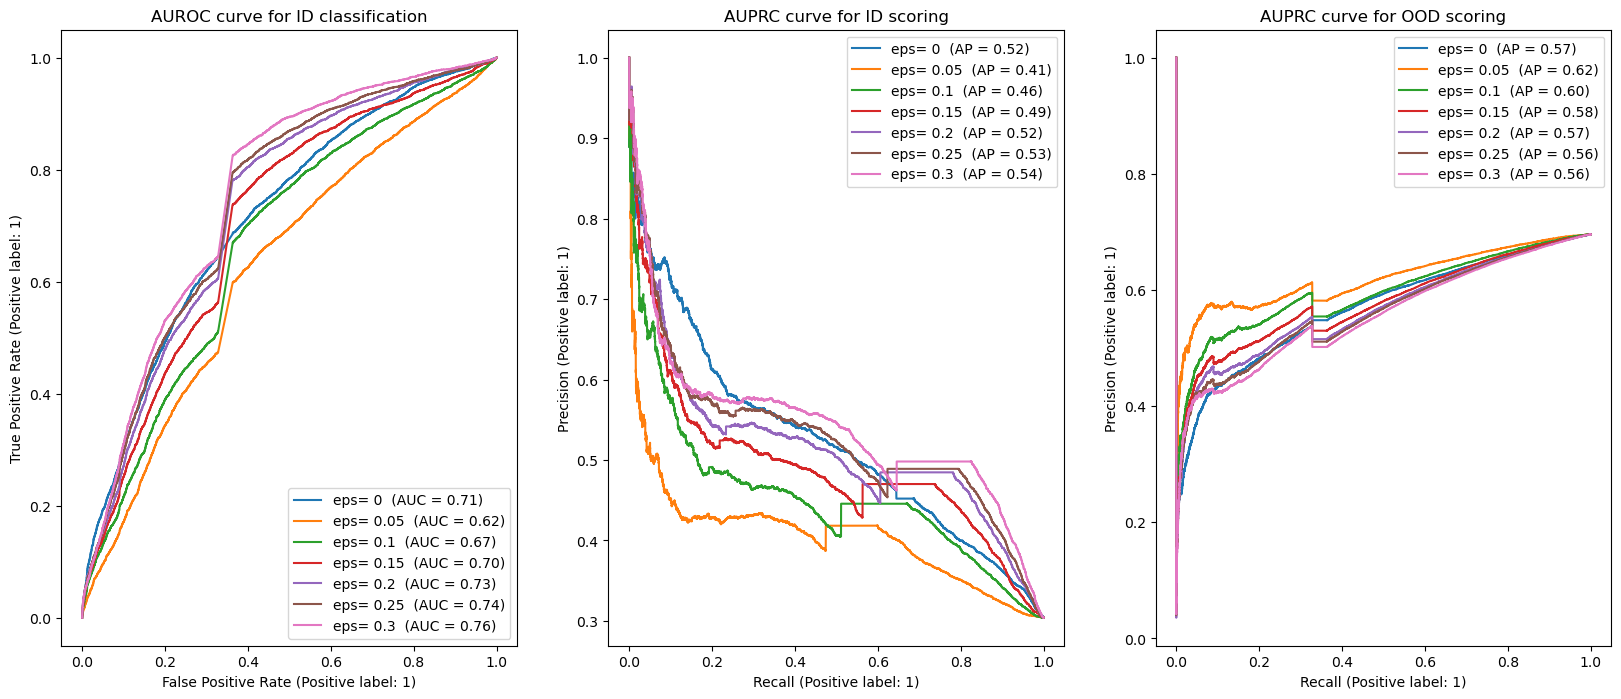

In [23]:
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
pretrained_model = "./model/model.pth"
torch.manual_seed(42)

test_loader = in_data  ############

accuracies = []
examples = []

fig, axs = plt.subplots(1, 3, figsize=(20, 8))  # 1 row, 3 columns

for eps in epsilons:
    acc, ex, logits = test(model, device, test_loader, eps)

    logits_ID = logits
    logits_OOD = collect_logits(model, ood_data)

    roc_curve(logits_ID=logits_ID, logits_OOD=logits_OOD, eps=eps, ax=axs[0])
    pr_curve(
        logits_ID=logits_ID,
        logits_OOD=logits_OOD,
        label_positive="id",
        eps=eps,
        ax=axs[1],
    )

    pr_curve(
        logits_ID=logits_ID,
        logits_OOD=logits_OOD,
        label_positive="ood",
        eps=eps,
        ax=axs[2],
    )

    accuracies.append(acc)
    examples.append(ex)
plt.show()

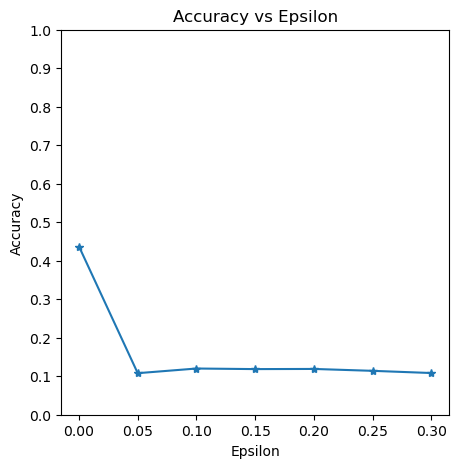

In [24]:
plt.figure(figsize=(5, 5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

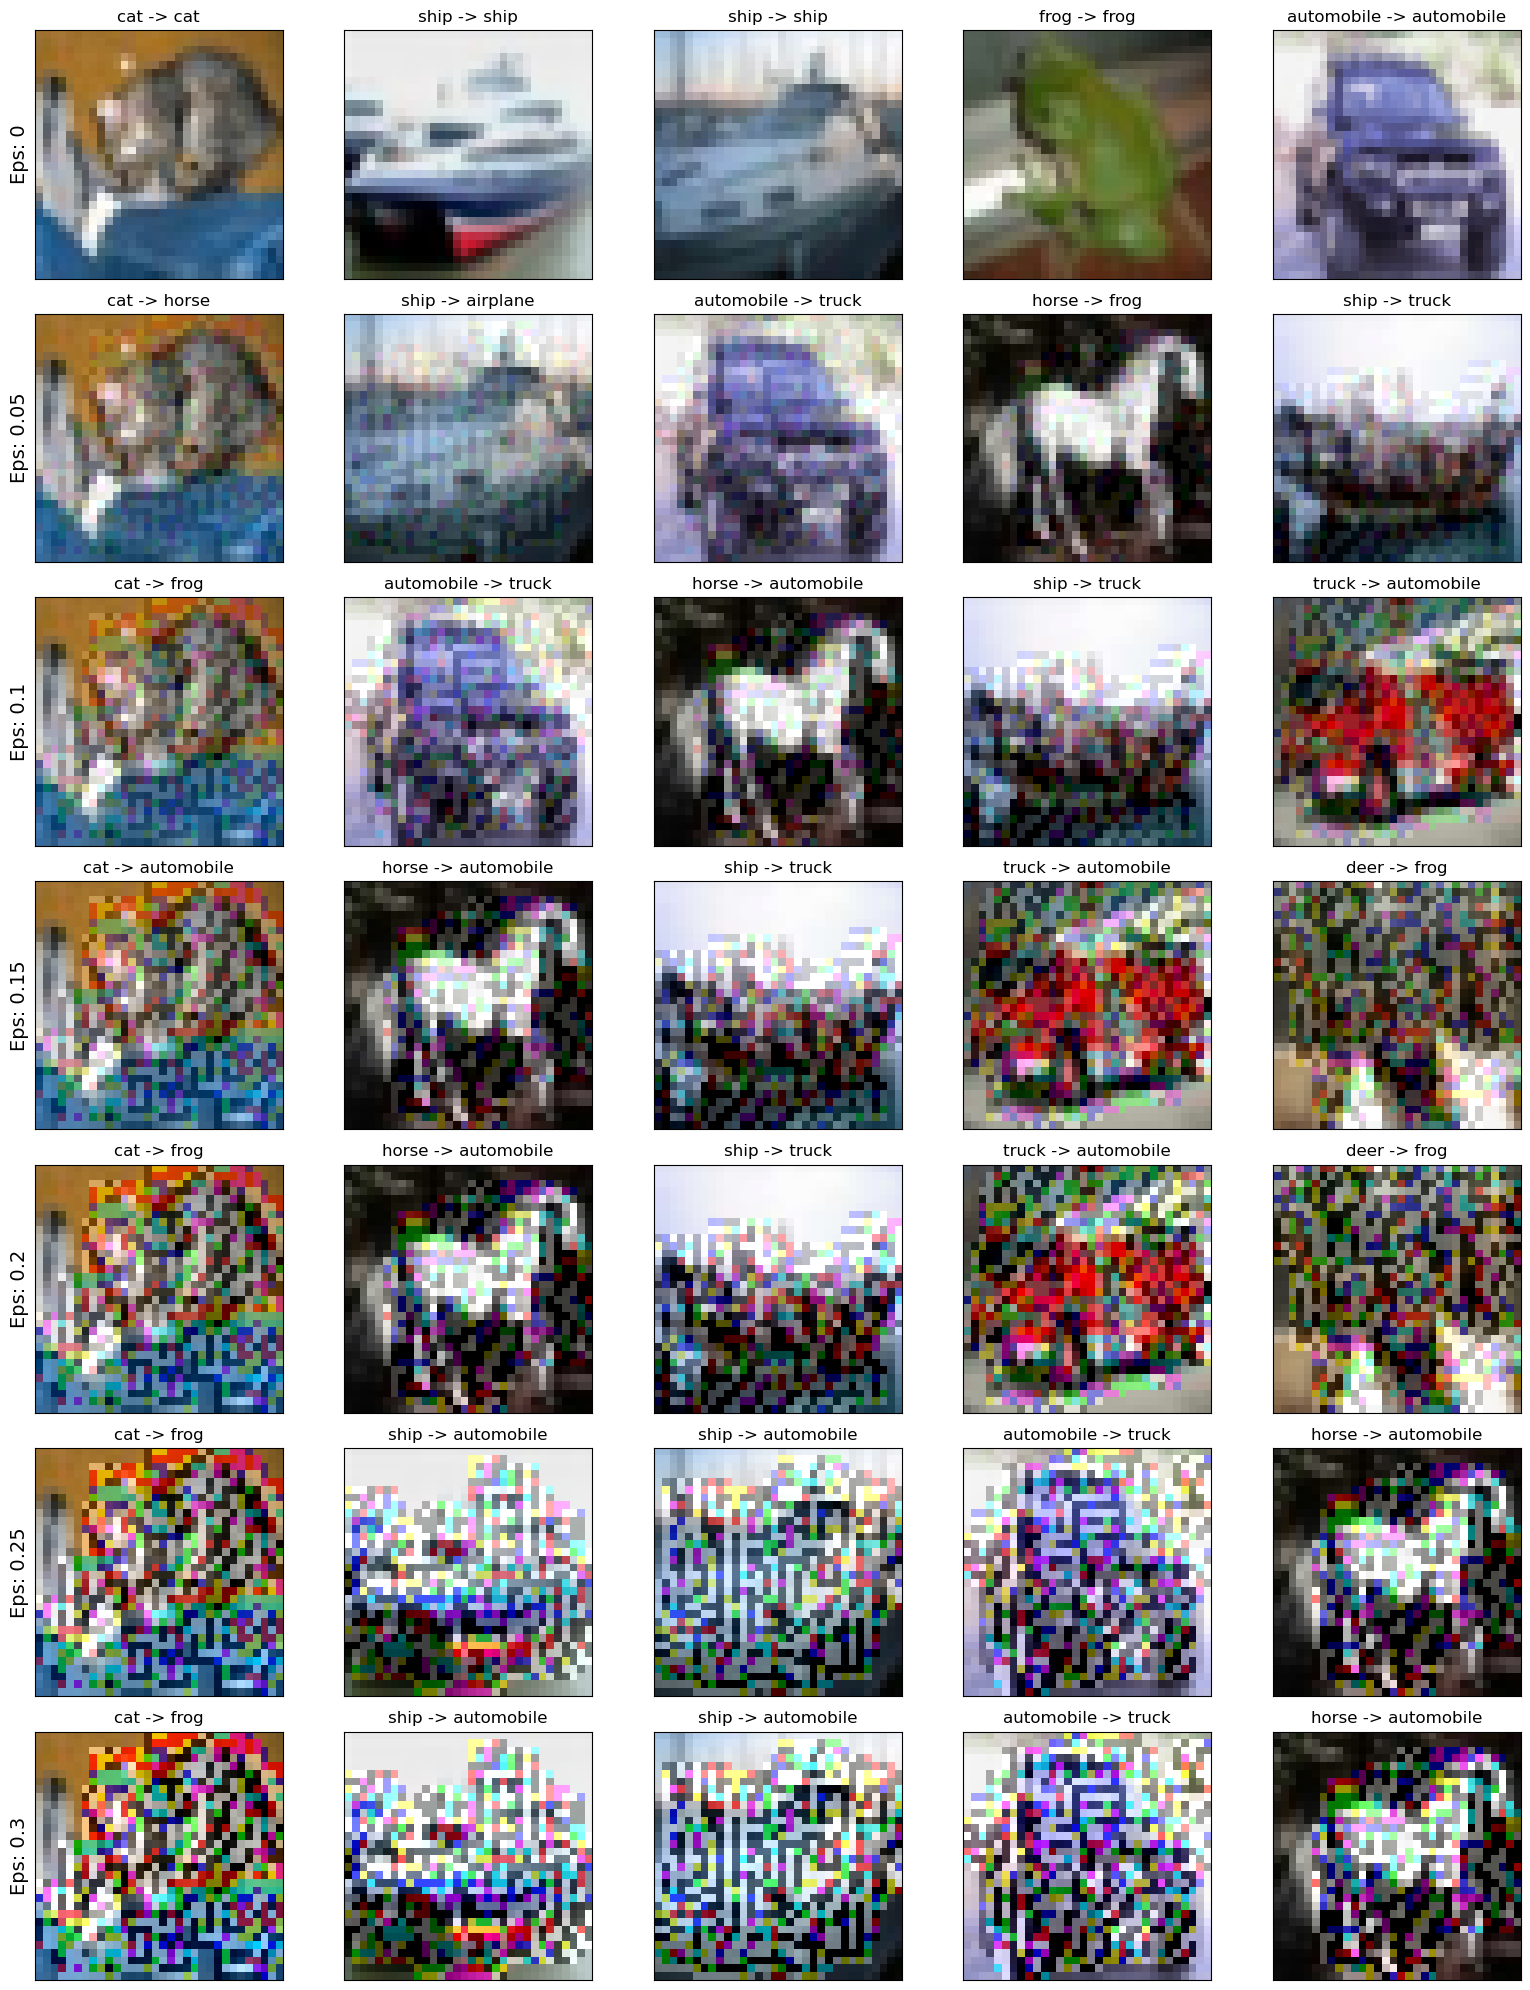

In [25]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(16, 20))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]), cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title(f"{id2label[orig]} -> {id2label[adv]}")
        image_visualized = np.transpose(ex, (1, 2, 0))
        plt.imshow(image_visualized, cmap="gray")
plt.tight_layout()
plt.show()

<span style="color: green;">

---

## Exercise 3: Wildcard

You know the drill. Pick _ONE_ of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection <span style="color: red;">(DONE)</span>

ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN

In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a _discriminator_ to your model to encourage the adversarial samples used for regularization to be more _salient_.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with _targeted_ adversarial attacks

Implement the targeted Fast Gradient Sign Method to generate adversarial samples that _imitate_ samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.

</span>


## ODIN


In [56]:
# input preprocessing: perturba l'input dei sample del test usando l'iperparaemtro eps
# dai l'input in pasto alla rete e calcola la softmax con temperatura
# calcola il valore max della probabilità (l'indice relativo al valore max è la label)
# fissa una soglia delta e confrontala con il valore max della probabilità
# trova i parametri T, eps affinche il TPR sia 95% (usa optuna)

In [57]:
def perturbed_image(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


# restores the tensors to their original scale
def denorm(
    batch,
    mean=[0.49139968, 0.48215841, 0.44653091],
    std=[0.24703223, 0.24348513, 0.26158784],
):
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)


def odin_detector(softmax_score, threshold):
    return softmax_score > threshold


def calculate_delta(softmax_score, labels):
    _, recall, thresholds = precision_recall_curve(labels, softmax_score)
    min_recall = np.argmin(recall > 0.95)
    return thresholds[min_recall]

In [58]:
def create_dataset_perturbed(model, device, test_loader, epsilon, T):
    x_adv = []
    y_adv = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        data.requires_grad = True

        output = model(data)
        max_index = torch.max(output, dim=1)[1]

        loss = F.cross_entropy(output / T, max_index)
        model.zero_grad()  # è necessario?
        loss.backward()

        data_grad = torch.log(data.grad.data)
        data_denorm = denorm(data)

        perturbed_data = perturbed_image(data_denorm, epsilon, data_grad)

        perturbed_data_normalized = transforms.Normalize(
            (0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)
        )(perturbed_data)

        x_adv.append(perturbed_data_normalized)
        y_adv.append(target)
    ds = torch.utils.data.TensorDataset(
        torch.cat(x_adv, dim=0), torch.cat(y_adv, dim=0)
    )
    return torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=False)

In [59]:
def odin_score(dl, model, T, eps):
    dl_odin = create_dataset_perturbed(model, device, dl, eps, T)
    logits = collect_logits(model, dl_odin)
    prob = torch.softmax(logits / T, dim=1)  # temperature scaling
    softmax_score = torch.max(prob, dim=1).values
    return softmax_score.numpy()


def score(dl, model, T, eps):
    return odin_score(dl, model, T, eps)

In [60]:
T = 0.2
eps = 0.3

In [61]:
scores_IN = score(in_data, model, T, eps)
scores_OOD = score(ood_data, model, T, eps)

In [62]:
labels_ID = np.array([1 for _ in range(len(in_data.dataset))])
labels_OOD = np.array([0 for _ in range(len(ood_data.dataset))])
labels = np.concatenate([labels_ID, labels_OOD])

scores = np.concatenate([scores_IN, scores_OOD])

In [63]:
threshold = calculate_delta(scores, labels)
predictions = odin_detector(scores, threshold)
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.55      0.06      0.11     10000
           1       0.50      0.95      0.66     10000

    accuracy                           0.51     20000
   macro avg       0.53      0.51      0.38     20000
weighted avg       0.53      0.51      0.38     20000



In [64]:
print(f"AUROC: {roc_auc_score(labels, scores)}")
print(f"AP: {average_precision_score(labels, scores)}")

AUROC: 0.53641163
AP: 0.5286547448486596


In [65]:
def roc_curve(dl_in, dl_out, scores_in, scores_ood, eps, T, ax):
    labels_ID = np.array([1 for _ in range(len(dl_in.dataset))])
    labels_OOD = np.array([0 for _ in range(len(dl_out.dataset))])
    y = np.concatenate([labels_ID, labels_OOD])
    pred = np.concatenate([scores_in, scores_ood])

    if ax is not None:
        RocCurveDisplay.from_predictions(y, pred, ax=ax, name=f"eps= {eps}, T = {T} ")
        ax.set_title("AUROC curve for ID classification")
        ax.legend(loc="best")


def pr_curve(dl_in, dl_out, scores_in, scores_ood, label_positive, eps, T, ax):
    if label_positive == "id":
        labels_ID = np.array([1 for _ in range(len(dl_in.dataset))])
        labels_OOD = np.array([0 for _ in range(len(dl_out.dataset))])
        title = "AUPRC curve for ID scoring"
    if label_positive == "ood":
        labels_ID = np.array([0 for _ in range(len(dl_in.dataset))])
        labels_OOD = np.array([1 for _ in range(len(dl_out.dataset))])
        title = "AUPRC curve for OOD scoring"

    y = np.concatenate([labels_ID, labels_OOD])
    pred = np.concatenate([scores_in, scores_ood])

    if ax is not None:
        PrecisionRecallDisplay.from_predictions(
            y, pred, ax=ax, name=f"eps= {eps}, T = {T} "
        )
        ax.set_title(title)
        ax.legend(loc="best")

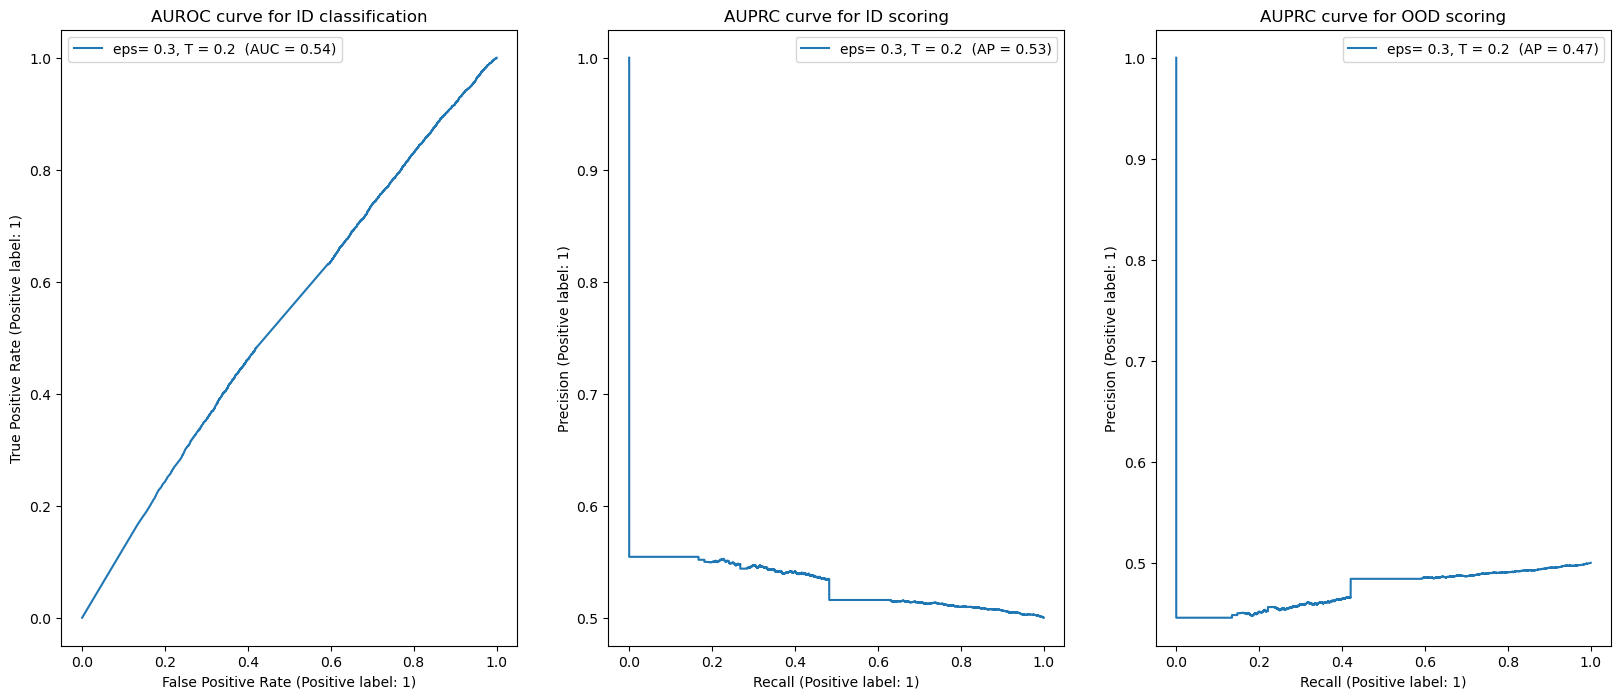

In [66]:
torch.manual_seed(42)


fig, axs = plt.subplots(1, 3, figsize=(20, 8))  # 1 row, 3 columns

roc_curve(in_data, ood_data, scores_IN, scores_OOD, eps=eps, T=T, ax=axs[0])
pr_curve(
    in_data,
    ood_data,
    scores_IN,
    scores_OOD,
    label_positive="id",
    eps=eps,
    T=T,
    ax=axs[1],
)

pr_curve(
    in_data,
    ood_data,
    scores_IN,
    scores_OOD,
    label_positive="ood",
    eps=eps,
    T=T,
    ax=axs[2],
)

plt.show()

In [74]:
labels_ID = np.array([1 for _ in range(len(in_data.dataset))])
labels_OOD = np.array([0 for _ in range(len(ood_data.dataset))])
y = np.concatenate([labels_ID, labels_OOD])

best_roc = -float("inf")
best_params = None

for T in np.linspace(100, 10000, 10):
    for eps in np.linspace(0.00001, 0.0001, 10):
        scores_ID = odin_score(in_data, model, T, eps)
        scores_OOD = odin_score(ood_data, model, T, eps)
        scores = np.concatenate([scores_ID, scores_OOD])

        roc = roc_auc_score(labels, scores)

        if roc > best_roc:
            best_roc = roc
            best_params = [T, eps]
            print(f"T: {T:.1f} | eps: {eps:.4f} | roc: {roc:.3f} --> BEST")
        else:
            print(f"T: {T:.1f} | eps: {eps:.4f} | roc: {roc:.3f}")

T: 1.0 | eps: 0.0001 | roc: 0.605 --> BEST


KeyboardInterrupt: 

In [73]:
T = best_params[0]
esp = best_params[1]

[10000.0, 0.0001]

In [70]:
scores_IN = score(in_data, model, T, eps)
scores_OOD = score(ood_data, model, T, eps)

In [71]:
labels_ID = np.array([1 for _ in range(len(in_data.dataset))])
labels_OOD = np.array([0 for _ in range(len(ood_data.dataset))])
labels = np.concatenate([labels_ID, labels_OOD])

scores = np.concatenate([scores_IN, scores_OOD])
threshold = calculate_delta(scores, labels)
predictions = odin_detector(scores, threshold)
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.62      0.08      0.15     10000
           1       0.51      0.95      0.66     10000

    accuracy                           0.52     20000
   macro avg       0.57      0.52      0.40     20000
weighted avg       0.57      0.52      0.40     20000



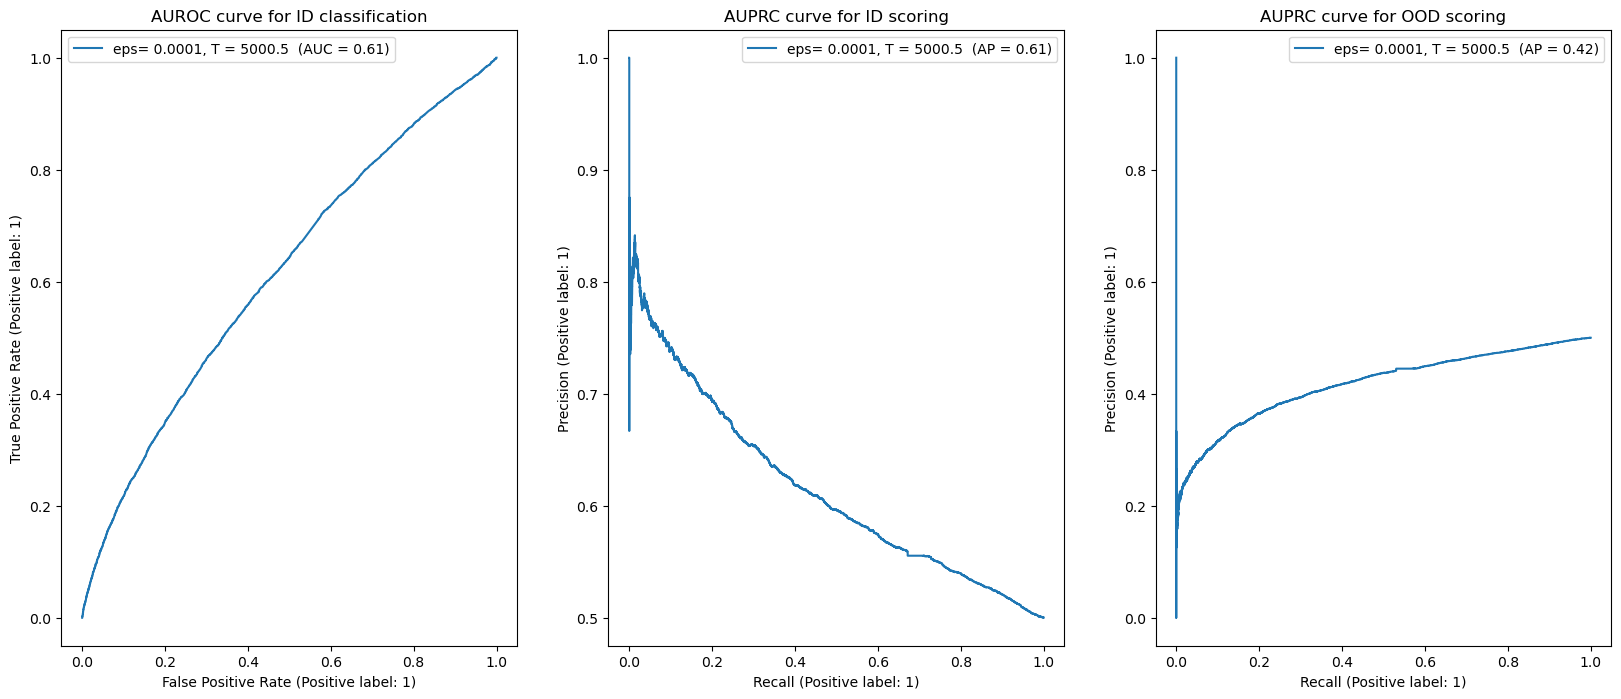

In [72]:
torch.manual_seed(42)


fig, axs = plt.subplots(1, 3, figsize=(20, 8))  # 1 row, 3 columns

roc_curve(in_data, ood_data, scores_IN, scores_OOD, eps=eps, T=T, ax=axs[0])
pr_curve(
    in_data,
    ood_data,
    scores_IN,
    scores_OOD,
    label_positive="id",
    eps=eps,
    T=T,
    ax=axs[1],
)

pr_curve(
    in_data,
    ood_data,
    scores_IN,
    scores_OOD,
    label_positive="ood",
    eps=eps,
    T=T,
    ax=axs[2],
)

plt.show()